In [ ]:
!pip install planarity

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.7/257.7 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for planarity: filename=planarity-0.6-cp310-cp310-linux_x86_64.whl size=423621 sha256=4b8740d673b4dd3bcb2e3d4d8b4ca03254ec4089314b260360ad7cac827eb0b7
  Stored in directory: /root/.cache/pip/wheels/b0/f4/97/991f06dfbef7b229e25f7728a6265f742045b79217dd169550
Successfully built planarity


Graph is planar. Using planar layout.


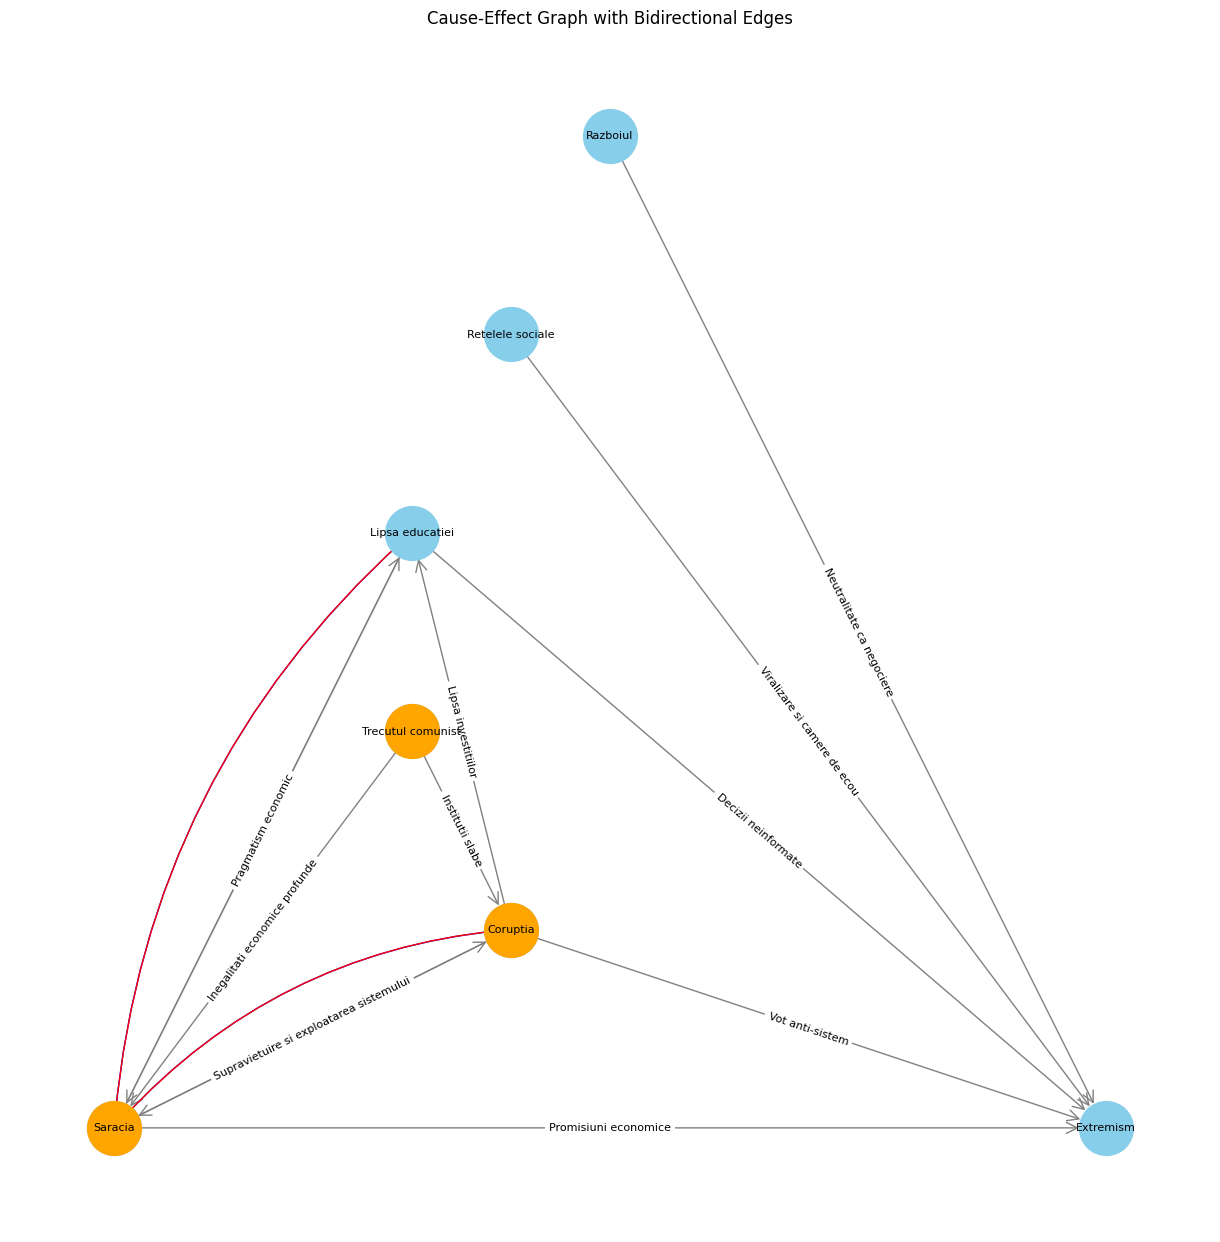

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

def create_and_draw_graph(filename):
    """
    Reads a file with cause-effect pairs and optional edge labels,
    creates a directed graph, and draws it with arrows.
    Highlights the top 3 nodes with the most descendants (total influence).
    Attempts to draw without edge intersections if the graph is planar.
    Uses curved edges for bidirectional links to reduce ambiguity.

    Args:
      filename: The name of the file containing the pairs.
            Format: cause,effect,edge_label (comma-separated)
            edge_label is optional
    """

    graph = nx.DiGraph()  # Directed graph
    edge_labels = {}
    bidirectional_edges = set()  # To store bidirectional edges
    with open(filename, 'r') as f:
        for line in f:
            parts = [part.strip() for part in line.strip().split(',')]
            cause = parts[0]
            effect = parts[1]
            graph.add_edge(cause, effect)
            if len(parts) == 3:
                edge_labels[(cause, effect)] = parts[2]

            # Identify bidirectional edges by checking if the reverse edge exists
            if graph.has_edge(effect, cause):
                bidirectional_edges.add((cause, effect))
                bidirectional_edges.add((effect, cause))

    # Calculate descendants for each node
    descendants_count = {node: len(nx.descendants(graph, node)) for node in graph.nodes()}

    # Identify the top 3 nodes with the most descendants
    sorted_nodes_by_descendants = sorted(descendants_count.items(), key=lambda x: x[1], reverse=True)
    most_causative_nodes = [node for node, count in sorted_nodes_by_descendants[:3]]

    # Check for planarity and choose layout accordingly
    if nx.check_planarity(graph)[0]:
        print("Graph is planar. Using planar layout.")
        pos = nx.planar_layout(graph)  # Get a planar layout
    else:
        print("Graph is not planar. Drawing with spring layout.")
        pos = nx.spring_layout(graph, k=0.2, seed=42)  # Adjust k to spread out nodes

    # Increase the figure size to give more space
    plt.figure(figsize=(12, 12))  # Change this to adjust figure size

    # Draw the graph
    nx.draw(graph, pos, with_labels=True, node_size=1500, node_color="skyblue",
            font_size=8, font_color="black", arrowsize=20, arrowstyle='->', edge_color='gray')

    # Highlight the top 3 most causative nodes
    nx.draw_networkx_nodes(
        graph, pos, nodelist=most_causative_nodes, node_color='orange', node_size=1500)

    # Draw edge labels
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=8)

    # Draw bidirectional edges as curved arrows
    for cause, effect in bidirectional_edges:
        # Skip one direction to avoid duplicate edges
        if (effect, cause) in bidirectional_edges and (cause, effect) > (effect, cause):
            continue
        # Draw curved edges for bidirectional links
        nx.draw_networkx_edges(
            graph, pos,
            edgelist=[(cause, effect)],
            connectionstyle='arc3,rad=0.2',  # Curve outward
            edge_color='blue', arrowstyle='->', arrowsize=20
        )
        nx.draw_networkx_edges(
            graph, pos,
            edgelist=[(effect, cause)],
            connectionstyle='arc3,rad=-0.2',  # Curve inward
            edge_color='red', arrowstyle='->', arrowsize=20
        )

    plt.title("Cause-Effect Graph with Bidirectional Edges")
    plt.show()

# Example usage:
filename = 'cause_effect_pairs.txt'
create_and_draw_graph(filename)


In [ ]:
!apt-get install graphviz graphviz-dev
!pip install pygraphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'libgraphviz-dev' instead of 'graphviz-dev'
graphviz is already the newest version (2.42.2-6ubuntu0.1).
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libgvc6-plugins-gtk
  librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 49 not upgraded.
Need to get 2,434 kB of archives.
After this operation, 7,681 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2.1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-0 amd64 2.24.33-2ubuntu2.1 [2,038 kB]
Get:3 http://a

In [ ]:
import networkx as nx
import pygraphviz as pgv  # Use pygraphviz

def parse_dot_file(dot_file):
    """Parse a Graphviz DOT file into a NetworkX graph using pygraphviz."""
    graph = pgv.AGraph(dot_file)
    G = nx.DiGraph(graph)  # Directly create from pygraphviz AGraph
    return G

def find_influences(G, excluded_nodes):
    """Find and compute the influence of each node based on the number of descendants."""
    influences = {node: 0 for node in G.nodes() if node not in excluded_nodes}

    # DFS to find all descendants of a node
    def dfs(node, visited):
        visited.add(node)
        count = 1  # Count the node itself
        for neighbor in G.neighbors(node):  # Traverse downstream
            if neighbor not in visited:
                count += dfs(neighbor, visited)
        return count

    # Compute the influence (number of descendants) for each node
    for node in G.nodes():
        if node not in excluded_nodes:
            visited = set()
            influences[node] = dfs(node, visited) - 1  # Subtract 1 to exclude the node itself

    return influences

def select_top_influencers(influences, top_percentage=0.2):
    """Select the nodes with the top X% influence based on their descendant count."""
    # Sort the nodes by their influence in descending order
    sorted_influences = sorted(influences.items(), key=lambda x: x[1], reverse=True)

    # Calculate the number of top nodes to select
    num_top_nodes = int(len(sorted_influences) * top_percentage)

    # Select the top X% nodes
    top_nodes = sorted_influences[:num_top_nodes]
    return top_nodes

def find_critical_nodes(G, excluded_nodes):
    """Find critical nodes with a high number of incoming edges, excluding certain nodes."""
    # Exclude specific nodes from the critical node analysis
    incoming_influence = {node: len(list(G.predecessors(node))) for node in G.nodes() if node not in excluded_nodes}

    # Sort the nodes by incoming influence (number of incoming edges)
    sorted_critical_nodes = sorted(incoming_influence.items(), key=lambda x: x[1], reverse=True)

    return sorted_critical_nodes

def select_top_critical_nodes(critical_nodes, top_percentage=0.2):
    """Select the top X% of critical nodes based on their incoming influence."""
    num_top_nodes = int(len(critical_nodes) * top_percentage)
    top_critical_nodes = critical_nodes[:num_top_nodes]
    return top_critical_nodes

def print_all_influences(influences):
    """Print all nodes and their influence scores, sorted by influence."""
    # Sort nodes by influence in descending order
    sorted_influences = sorted(influences.items(), key=lambda x: x[1], reverse=True)

    print("All nodes and their influence (number of descendants), sorted:")
    for node, influence in sorted_influences:
        print(f"{node}: {influence}")

def print_influence_ranking(top_nodes):
    """Print the nodes with the highest influence (top 20%)."""
    print(f"\nTop {len(top_nodes)} nodes by influence (based on number of descendants):")
    for node, influence in top_nodes:
        print(f"{node}: {influence}")

def print_critical_nodes(critical_nodes):
    """Print the critical nodes with the highest incoming influence."""
    print("\nCritical nodes (with the most incoming influence):")
    for node, incoming in critical_nodes:
        print(f"{node}: {incoming} incoming edges")

def print_top_critical_nodes(top_critical_nodes):
    """Print the top critical nodes selected by Pareto analysis (top 20%)."""
    print(f"\nTop {len(top_critical_nodes)} critical nodes by incoming influence (Pareto analysis):")
    for node, incoming in top_critical_nodes:
        print(f"{node}: {incoming} incoming edges")

if __name__ == "__main__":
    dot_file = "extremism_romania.dot"  # Update this path if necessary
    G = parse_dot_file(dot_file)

    # Define nodes that cannot be changed (including 'extremism')
    excluded_nodes = {"trecut_comunist", "razboi_ucraina", "extremism"}

    # Compute the influence of each node (based on the number of descendants, excluding fixed nodes)
    influences = find_influences(G, excluded_nodes)

    # Print all nodes and their influence, sorted
    print_all_influences(influences)

    # Select the top 20% of nodes by influence (Pareto)
    top_nodes = select_top_influencers(influences, top_percentage=0.25)

    # Print the influence ranking of top nodes
    print_influence_ranking(top_nodes)

    # Find the critical nodes based on incoming influence
    critical_nodes = find_critical_nodes(G, excluded_nodes)

    # Print the critical nodes sorted by incoming influence
    print_critical_nodes(critical_nodes)

    # Select the top 20% of critical nodes (Pareto analysis)
    top_critical_nodes = select_top_critical_nodes(critical_nodes, top_percentage=0.25)

    # Print the top critical nodes selected by Pareto analysis
    print_top_critical_nodes(top_critical_nodes)


All nodes and their influence (number of descendants), sorted:
coruptie: 10
saracie: 9
educatie_precara: 9
manipulare: 7
social_media: 5
nationalism: 4
polarizare: 3
autoritarism: 1
propaganda: 1
anti_sistem: 1
homofobie: 1
cheie: 0

Top 3 nodes by influence (based on number of descendants):
coruptie: 10
saracie: 9
educatie_precara: 9

Critical nodes (with the most incoming influence):
autoritarism: 5 incoming edges
social_media: 4 incoming edges
anti_sistem: 4 incoming edges
polarizare: 4 incoming edges
saracie: 3 incoming edges
educatie_precara: 3 incoming edges
homofobie: 3 incoming edges
propaganda: 2 incoming edges
coruptie: 1 incoming edges
manipulare: 1 incoming edges
nationalism: 1 incoming edges
cheie: 0 incoming edges

Top 3 critical nodes by incoming influence (Pareto analysis):
autoritarism: 5 incoming edges
social_media: 4 incoming edges
anti_sistem: 4 incoming edges
